In [66]:
!pip install --upgrade duckdb


In [67]:
import duckdb
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, auc
from collections import Counter
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import pickle

In [68]:
    conn = duckdb.connect('data.duckdb')
    query = """
    SELECT
        fy.*,
        ed.emtak, ed.status, ed.type, ed.legal_form,
        fp.current_assets, fp.current_liabilities, fp.non_current_assets,
        fp.non_current_liabilities, fp.revenue, fp.profit_loss,
        fp.total_profit_loss, fp.labour_expense,
        fp.cash, fp.equity, fp.issued_capital, fp.assets
    FROM fy_report_dim fy
    LEFT JOIN entity_dim ed ON fy.entity_id = ed.entity_id
    LEFT JOIN financial_performance_fact fp ON fy.fy_report_id = fp.fy_report_id
    """
    df = conn.execute(query).fetchdf()

df = df.drop(['entity_id', 'fy_report_id', 'audit_type','audit_decision', 'period_start', 'period_end','submission_date'], axis=1)




FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('audited', axis=1), df['audited'], test_size=0.2, random_state=47)

In [71]:
# Define preprocessing for numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Pipelines for handling missing values and encoding
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1))  # Handle missing numerical values
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Apply transformation
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [72]:
# 1. Check initial class distribution:
class_distribution = Counter(y_train)
majority_class = max(class_distribution, key=class_distribution.get)
minority_class = min(class_distribution, key=class_distribution.get)

# 2. Apply Random Undersampling only if majority class is more than 6x the minority class
if class_distribution[majority_class] > 6 * class_distribution[minority_class]:
    undersampler_ru = RandomUnderSampler(sampling_strategy={majority_class: 6 * class_distribution[minority_class]}, random_state=47)
    X_train_processed, y_train = undersampler_ru.fit_resample(X_train_processed, y_train)

# 3. Apply SMOTE to balance classes completely:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# 4. Train XGBoost model
model = XGBClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# 5. Predict and evaluate
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]  # For ROC AUC

# 6. Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 7. Print results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.9914898187129478
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00    223650
        True       0.85      0.95      0.90      9130

    accuracy                           0.99    232780
   macro avg       0.92      0.97      0.95    232780
weighted avg       0.99      0.99      0.99    232780

ROC AUC Score: 0.9973669770846081


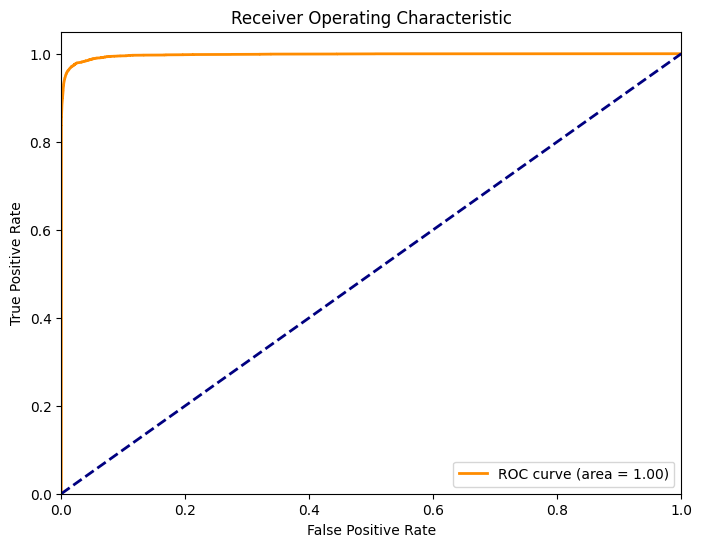

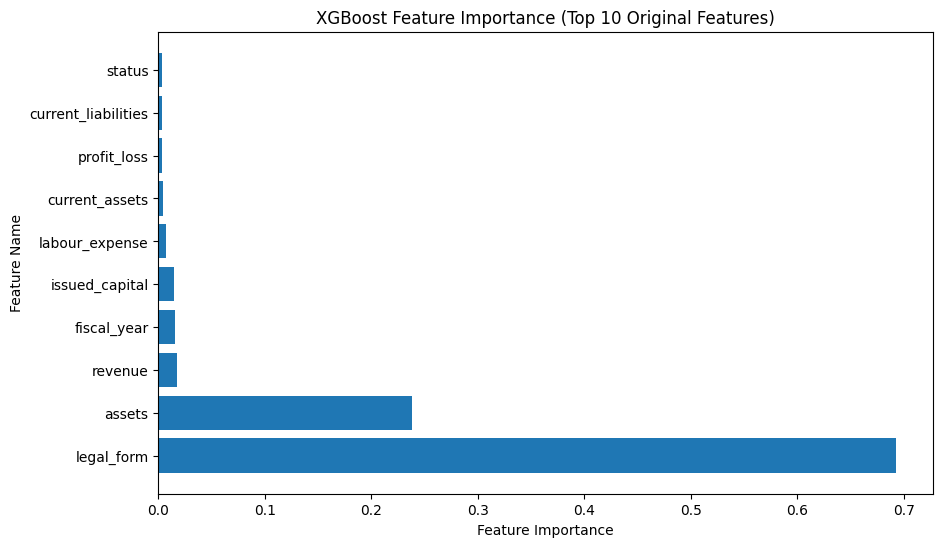

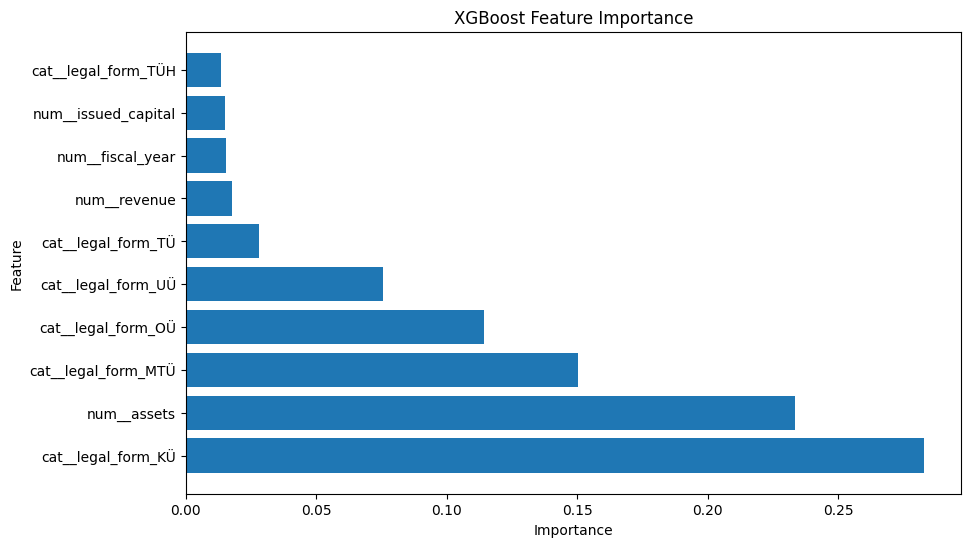

In [73]:
# ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
feature_importance = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Get original feature names from ColumnTransformer
original_feature_names = numerical_cols.tolist() + categorical_cols.tolist()

# Create a mapping between original and transformed feature names
feature_mapping = {}
for i, orig_name in enumerate(original_feature_names):
    feature_mapping[orig_name] = []
    for transformed_name in feature_names:
        if transformed_name.endswith(orig_name) or transformed_name.startswith(f"cat__{orig_name}"):  # Handle num and cat prefixes
            feature_mapping[orig_name].append(transformed_name)

# Calculate importance for original features
original_feature_importance = {}
for orig_name, transformed_names in feature_mapping.items():
    original_feature_importance[orig_name] = sum(feature_importance[np.where(np.isin(feature_names, transformed_names))[0]])

# Sort by importance
sorted_features = sorted(original_feature_importance.items(), key=lambda item: item[1], reverse=True)

# Get top 10 original features
top_features = sorted_features[:10]

# Create plot
feature_names, importance_values = zip(*top_features)
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('XGBoost Feature Importance (Top 10 Original Features)')
plt.show()

# Get feature importance and names
feature_importance = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))

top_features = feature_importance_df.head(10)

plt.barh(top_features['feature'], top_features['importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [74]:
# Save the test set to a file
with open('test_set.pkl', 'wb') as file:
    pickle.dump({'X_test': X_test, 'y_test': y_test}, file)

# Save the trained model to a file
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Save the preprocessor to a file
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

# Download the files
files.download('test_set.pkl')
files.download('trained_model.pkl')
files.download('preprocessor.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
audited_indices = y_test[y_test == True].index

example_index = audited_indices[1]
example = X_test.loc[example_index]

legal_form = example['legal_form']
assets = example['assets']
revenue = example['revenue']

print(f"Legal Form: {legal_form}")
print(f"Assets: {assets}")
print(f"Revenue: {revenue}")

Legal Form: OÜ
Assets: 1733533.0
Revenue: 2393835.0
